In [5]:
%reload_ext autoreload
%autoreload 2

from fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

 
from cifar_models import *
from utils.dataset import *
from utils.image_utils import *
from cifar_models.vgg import *
from cifar_models.resnet import *
device = "cuda" if torch.cuda.is_available() else "cpu"

plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 13

In [6]:
exp_results_folder = "exp_results/"

jpeg1_vgg11 = np.load(exp_results_folder + "vgg11_jpeg1.npz")
jpeg5_vgg11 = np.load(exp_results_folder + "vgg11_jpeg5.npz")
jpeg10_vgg11 = np.load(exp_results_folder + "vgg11_jpeg10.npz")
jpeg20_vgg11 = np.load(exp_results_folder + "vgg11_jpeg20.npz")
jpeg40_vgg11 = np.load(exp_results_folder + "vgg11_jpeg40.npz")
jpeg60_vgg11 = np.load(exp_results_folder + "vgg11_jpeg60.npz")

base_vgg11 = np.load(exp_results_folder + "vgg11_base.npz")
bls50_vgg11 = np.load(exp_results_folder + "vgg11_bls05.npz")
bls33_vgg11 = np.load(exp_results_folder + "vgg11_bls033.npz")
bls12_vgg11 = np.load(exp_results_folder + "vgg11_bls012.npz")
bls5_vgg11 = np.load(exp_results_folder + "vgg11_bls005.npz")
bls3_vgg11 = np.load(exp_results_folder + "vgg11_bls003.npz")
bls1_vgg11 = np.load(exp_results_folder + "vgg11_bls001.npz")

bmhj50_vgg11 = np.load(exp_results_folder + "vgg11_bm05.npz")
bmhj33_vgg11 = np.load(exp_results_folder + "vgg11_bm033.npz")
bmhj12_vgg11 = np.load(exp_results_folder + "vgg11_bm012.npz")
bmhj5_vgg11 = np.load(exp_results_folder + "vgg11_bm005.npz")
bmhj3_vgg11 = np.load(exp_results_folder + "vgg11_bm003.npz")
bmhj1_vgg11 = np.load(exp_results_folder + "vgg11_bm001.npz")

data_red_bls_vgg11 = [bls1_vgg11, bls3_vgg11, bls5_vgg11, bls12_vgg11, bls33_vgg11, bls50_vgg11]
data_red_bmhj_vgg11 = [bmhj1_vgg11, bmhj3_vgg11, bmhj5_vgg11, bmhj12_vgg11, bmhj33_vgg11, bmhj50_vgg11]
data_red_jpeg_vgg11 = [jpeg1_vgg11, jpeg5_vgg11, jpeg10_vgg11, jpeg20_vgg11, jpeg40_vgg11, jpeg60_vgg11]

In [7]:
exp_results_folder = "exp_results/"

jpeg1_res18 = np.load(exp_results_folder + "res18_jpeg1.npz")
jpeg5_res18 = np.load(exp_results_folder + "res18_jpeg5.npz")
jpeg10_res18 = np.load(exp_results_folder + "res18_jpeg10.npz")
jpeg20_res18 = np.load(exp_results_folder + "res18_jpeg20.npz")
jpeg40_res18 = np.load(exp_results_folder + "res18_jpeg40.npz")
jpeg60_res18 = np.load(exp_results_folder + "res18_jpeg60.npz")

base_res18 = np.load(exp_results_folder + "res18_base.npz")

bmhj50_res18 = np.load(exp_results_folder + "res18_bm05.npz")
bmhj33_res18 = np.load(exp_results_folder + "res18_bm033.npz")
bmhj12_res18 = np.load(exp_results_folder + "res18_bm012.npz")
bmhj5_res18 = np.load(exp_results_folder + "res18_bm005.npz")
bmhj3_res18 = np.load(exp_results_folder + "res18_bm003.npz")
bmhj1_res18 = np.load(exp_results_folder + "res18_bm001.npz")

data_red_bmhj_res18 = [bmhj1_res18, bmhj3_res18, bmhj5_res18, bmhj12_res18, bmhj33_res18, bmhj50_res18]
data_red_jpeg_res18 = [jpeg1_res18, jpeg5_res18, jpeg10_res18, jpeg20_res18, jpeg40_res18, jpeg60_res18]

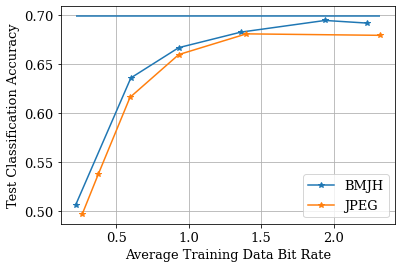

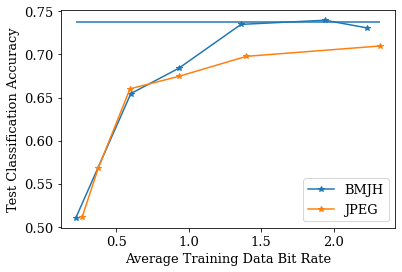

In [8]:
tiny_bmhj_bpp = [0.22, 0.6, 0.93, 1.36, 1.94, 2.23, 2.64]
tiny_bls_bpp = [0.257, 0.606, 0.859, 1.206, 1.596, 1.744]
tiny_jpeg_bpp = [0.265, 0.375, 0.594, 0.93, 1.397, 2.32]
key = "test_top5_acc" #test_top5_acc

plt.ylabel("Test Classification Accuracy")
plt.xlabel("Average Training Data Bit Rate")
# plt.plot(tiny_bls_bpp, [data[key].max() for data in data_red_bls_vgg11], label = "BLS")
plt.plot(tiny_bmhj_bpp[:-1], [data[key].max() for data in data_red_bmhj_vgg11], marker = "*", label = "BMJH")
plt.plot(tiny_jpeg_bpp, [data[key].max() for data in data_red_jpeg_vgg11], marker = "*", label = "JPEG")
plt.hlines(base_vgg11[key].max(), 0.22, 2.32)
plt.grid()
plt.legend(loc=4)
plt.show()

plt.ylabel("Test Classification Accuracy")
plt.xlabel("Average Training Data Bit Rate")
plt.plot(tiny_bmhj_bpp[:-1], [data[key].max() for data in data_red_bmhj_res18], marker = "*", label = "BMJH")
plt.plot(tiny_jpeg_bpp, [data[key].max() for data in data_red_jpeg_res18], marker = "*", label = "JPEG")
plt.hlines(base_res18[key].max(), 0.22, 2.32)
plt.legend(loc=4)
plt.show()

In [9]:
cifar_jpeg_bpp = [0.3559, 0.484, 0.7054, 1.034, 1.50, 1.91]
cifar_bls_bpp = [0.2612, 0.519, 0.69, 1.08, 1.48712, 1.63, 1.91]
res18_bls_res = [0.7238, 0.7871, 0.8155, 0.8309, 0.8359, 0.8299, 0.8264]
res18_jpeg_res = [0.6346, 0.7126, 0.7754, 0.8051, 0.8154, 0.8226]
vgg11_bls_res = [0.7122, 0.7606, 0.768, 0.7911, 0.8, 0.8007, 0.8045]
vgg11_jpeg_res = [0.6419, 0.7109, 0.7257, 0.7633, 0.7803, 0.7972]

base_vgg11_cifar = 0.8167
base_res18_cifar = 0.8357

0.7377


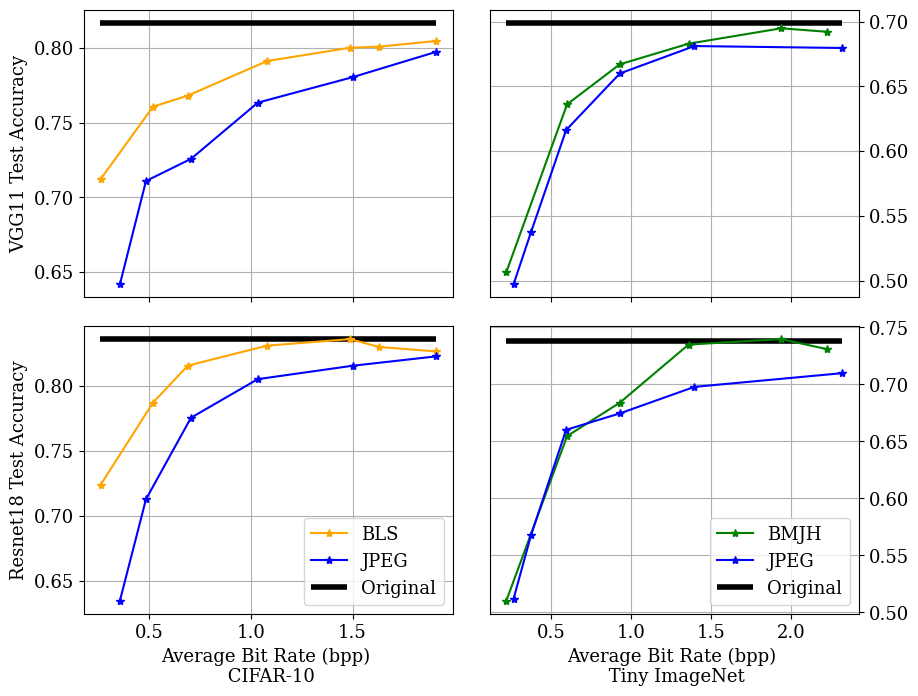

In [11]:
fig, axs = plt.subplots(2,2,figsize=(10,8), sharex="col", dpi = 100)

axs[0,0].set_ylabel("VGG11 Test Accuracy")
axs[0,0].plot(cifar_bls_bpp, vgg11_bls_res, marker = "*", label = "BLS", color = "orange")
axs[0,0].plot(cifar_jpeg_bpp, vgg11_jpeg_res, marker = "*", label = "JPEG", color = "blue")
axs[0,0].hlines(base_vgg11_cifar, 0.26, 1.91, color = "black", linewidth = 4, label = "Original")
axs[0,0].grid()

axs[1,0].set_ylabel("Resnet18 Test Accuracy")
axs[1,0].set_xlabel("Average Bit Rate (bpp) \n CIFAR-10")
axs[1,0].plot(cifar_bls_bpp, res18_bls_res, marker = "*", label = "BLS", color = "orange")
axs[1,0].plot(cifar_jpeg_bpp, res18_jpeg_res, marker = "*", label = "JPEG", color = "blue")
axs[1,0].hlines(base_res18_cifar, 0.26, 1.91, color = "black", linewidth = 4, label = "Original")
axs[1,0].legend(loc=4)
axs[1,0].grid()

axs[0,1].plot(tiny_bmhj_bpp[:-1], [data[key].max() for data in data_red_bmhj_vgg11], marker = "*", label = "BMJH", color = "green")
axs[0,1].plot(tiny_jpeg_bpp, [data[key].max() for data in data_red_jpeg_vgg11], marker = "*", label = "JPEG", color = "blue")
axs[0,1].hlines(base_vgg11[key].max(), 0.22, 2.32, color = "black", linewidth = 4, label = "Original")
axs[0,1].grid()

axs[1,1].set_xlabel("Average Bit Rate (bpp) \n Tiny ImageNet")
axs[1,1].plot(tiny_bmhj_bpp[:-1], [data[key].max() for data in data_red_bmhj_res18], marker = "*", label = "BMJH", color = "green")
axs[1,1].plot(tiny_jpeg_bpp, [data[key].max() for data in data_red_jpeg_res18], marker = "*", label = "JPEG", color = "blue")
axs[1,1].hlines(base_res18[key].max(), 0.22, 2.32, color = "black", linewidth = 4, label = "Original")
axs[1,1].legend(loc=4)
axs[1,1].grid()


axs[0,1].yaxis.set_label_position("right")
axs[0,1].yaxis.tick_right()

axs[1,1].yaxis.set_label_position("right")
axs[1,1].yaxis.tick_right()


# fig.text(0.04, 0.5, 'Test Classification Accuracy', va='center', rotation='vertical', fontsize=18)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.savefig("training.png")
print(base_res18[key].max())

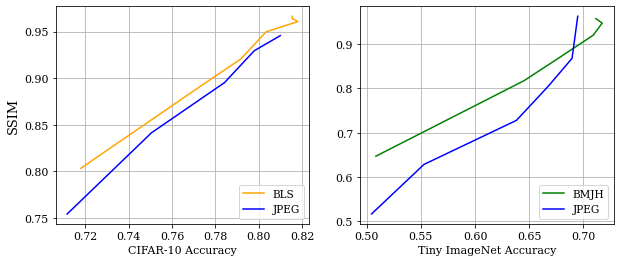

In [13]:
tiny_bmhj_ssim = [0.6468514695589016, 0.8178349294995872, 0.8660676283868756, 0.9201470542674022, 0.9476130723121283, 0.9579273307945654]
tiny_jpeg_ssim = [0.5164147054612853, 0.6282964751292837, 0.7278863544594766, 0.8041699122672109, 0.868010367403601, 0.9631890968846032]

cifar_bls_ssim = [0.8033611755066715, 0.8925222112445196, 0.9206221111020455, 0.9496784357041587, 0.9606196472540803, 0.9639560478472449, 0.9663533633433264]
cifar_jpeg_ssim = [0.6282734028726298, 0.7544690408452686, 0.8414159296752199, 0.8952277393712936, 0.9293016265473689, 0.9455897175998793]

bls_cifar_vals = [0.718  , 0.77385, 0.79175, 0.80335, 0.81795, 0.8153 , 0.81545]
jpeg_cifar_vals = [0.63825, 0.71175, 0.75055, 0.7842 , 0.79785, 0.8099 ]

bmhj_tiny_vals = (np.array([data[key].max() for data in data_red_bmhj_vgg11]) + np.array([data[key].max() for data in data_red_bmhj_res18]))/2
jpeg_tiny_vals = (np.array([data[key].max() for data in data_red_jpeg_vgg11]) + np.array([data[key].max() for data in data_red_jpeg_res18]))/2

fig, axs = plt.subplots(1,2, figsize = (10,4))
axs[0].set_ylabel("SSIM")
axs[0].set_xlabel("CIFAR-10 Accuracy", fontsize = 11)
axs[0].plot(bls_cifar_vals, cifar_bls_ssim,  label = "BLS", color = "orange")
axs[0].plot(jpeg_cifar_vals[1:], cifar_jpeg_ssim[1:], label= "JPEG", color = "blue")
axs[0].legend(loc = 4, fontsize = 10.5)
axs[0].tick_params(axis='both', which='major', labelsize=11)
axs[0].grid()

axs[1].set_xlabel("Tiny ImageNet Accuracy", fontsize = 11)
axs[1].plot(bmhj_tiny_vals, tiny_bmhj_ssim, label = "BMJH", color = "green")
axs[1].plot(jpeg_tiny_vals , tiny_jpeg_ssim, label= "JPEG", color = "blue")
axs[1].tick_params(axis='both', which='major', labelsize=11)
axs[1].legend(loc = 4, fontsize = 10.5)
axs[1].grid()
plt.savefig("ssim_accuracy.png")

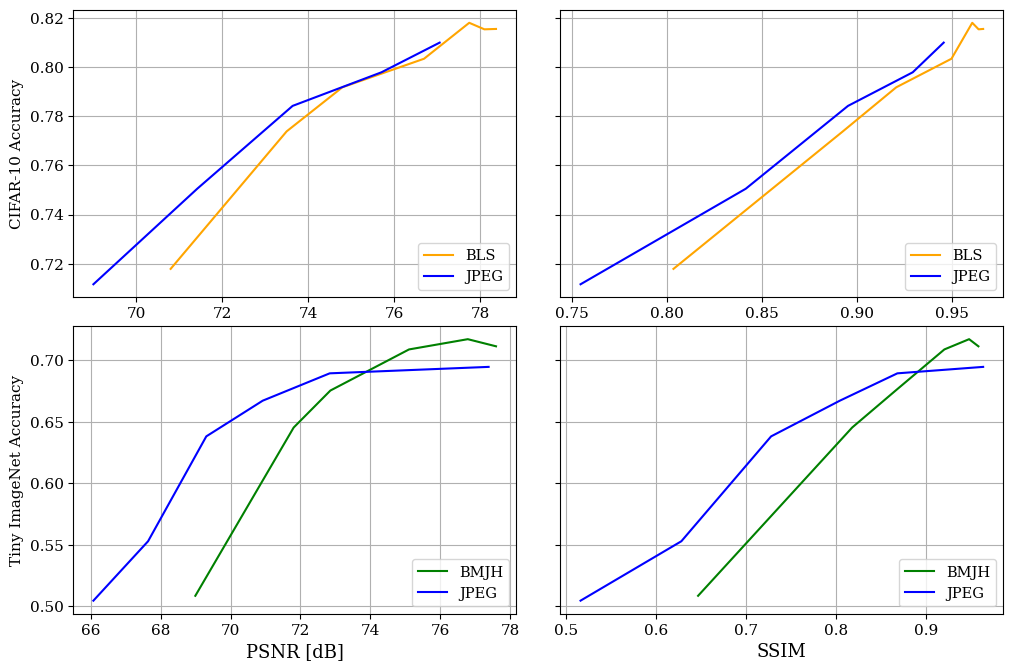

In [14]:
tiny_bmhj_psnr = [68.98837607384726, 71.80515044220253, 72.85641815928662, 75.10832200050257, 76.79166597111572, 77.59989025150645]
tiny_jpeg_psnr = [66.06938907747407, 67.63509148568933, 69.3024102572235, 70.91857720844554, 72.83737544130572, 77.38812423494146]

cifar_bls_psnr = [70.79729360853239, 73.4946560640531, 74.79034571820387, 76.68966325217183, 77.74087980823379, 78.09331479772197, 78.36313089528345]
cifar_jpeg_psnr = [66.77749201889438, 69.00128812822874, 71.41538589853432, 73.63346919222693, 75.70015984217537, 77.05283569886534]

bls_cifar_vals = [0.718  , 0.77385, 0.79175, 0.80335, 0.81795, 0.8153 , 0.81545]
jpeg_cifar_vals = [0.63825, 0.71175, 0.75055, 0.7842 , 0.79785, 0.8099 ]

bmhj_tiny_vals = (np.array([data[key].max() for data in data_red_bmhj_vgg11]) + np.array([data[key].max() for data in data_red_bmhj_res18]))/2
jpeg_tiny_vals = (np.array([data[key].max() for data in data_red_jpeg_vgg11]) + np.array([data[key].max() for data in data_red_jpeg_res18]))/2

fig, axs = plt.subplots(2,2, figsize = (12,8), sharey = "row", dpi = 100)
axs[0,0].set_ylabel("CIFAR-10 Accuracy", fontsize = 11)
axs[0,0].plot(cifar_bls_psnr, bls_cifar_vals,  label = "BLS", color = "orange")
axs[0,0].plot(cifar_jpeg_psnr[1:], jpeg_cifar_vals[1:], label= "JPEG", color = "blue")
axs[0,0].legend(loc = 4, fontsize = 10.5)
axs[0,0].tick_params(axis='both', which='major', labelsize=11)
axs[0,0].grid()

axs[1,0].set_xlabel("PSNR [dB]")
axs[1,0].set_ylabel("Tiny ImageNet Accuracy", fontsize = 11)
axs[1,0].plot(tiny_bmhj_psnr, bmhj_tiny_vals, label = "BMJH", color = "green")
axs[1,0].plot(tiny_jpeg_psnr, jpeg_tiny_vals , label= "JPEG", color = "blue")
axs[1,0].tick_params(axis='both', which='major', labelsize=11)
axs[1,0].legend(loc = 4, fontsize = 10.5)
axs[1,0].grid()

axs[0,1].plot(cifar_bls_ssim, bls_cifar_vals,  label = "BLS", color = "orange")
axs[0,1].plot(cifar_jpeg_ssim[1:], jpeg_cifar_vals[1:], label= "JPEG", color = "blue")
axs[0,1].legend(loc = 4, fontsize = 10.5)
axs[0,1].tick_params(axis='both', which='major', labelsize=11)
axs[0,1].grid()

axs[1,1].set_xlabel("SSIM")
axs[1,1].plot(tiny_bmhj_ssim, bmhj_tiny_vals, label = "BMJH", color = "green")
axs[1,1].plot(tiny_jpeg_ssim, jpeg_tiny_vals , label= "JPEG", color = "blue")
axs[1,1].tick_params(axis='both', which='major', labelsize=11)
axs[1,1].legend(loc = 4, fontsize = 10.5)
axs[1,1].grid()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)
plt.savefig("distortion_accuracy.png")

In [15]:
[data[key].max() for data in data_red_jpeg]

NameError: name 'data_red_jpeg' is not defined

In [20]:
[data[key].max() for data in data_red_bmhj]

[0.5067, 0.6193, 0.6671, 0.6719, 0.6878, 0.6778]

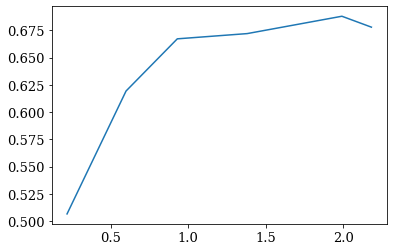

In [7]:
plt.plot(tiny_bmhj_bpp[:-1], [data[key].max() for data in data_red_bmhj], label = "BLS")